In [ ]:
!pip3 install essentia

First Task

Define the Duration and Offset measurement techniques.

We already have the onset detection ideas (HFC,)

Evaluate different onset.

Distances with annotation 


Similarity between Ground Truth (annotations) and the output of the algorithm.

Observations on current alg.

It needs to consider short inter-note interval.

Consider "missing green lines":

Can I find a way to 
numericall assess ag similar to student assessment.





Onset, Offset, Duration Measurements,

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
root = '/content/drive/Thesis'
query_music_path = '/content/drive/Thesis'

import pandas as pd
import sys
sys.path.append('/content/drive/Thesis')

sys.path.append('/content/drive/MyDrive/Thesis/IDMT-SMT-BASS_SINGLE-TRACKS/audio')
sys.path.append('/content/drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/annotation')




Mounted at /content/drive


In [ ]:
import os
from essentia.standard import *
from essentia import Pool, array
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [ ]:
!ls drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/annotation



001.xml  003.xml  005.xml  007.xml  009.xml  011.xml  013.xml  015.xml	017.xml
002.xml  004.xml  006.xml  008.xml  010.xml  012.xml  014.xml  016.xml


In [ ]:
from lxml import etree

with open("drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/annotation/002.xml", "rb") as f:
    tree = etree.parse(f)

golden_onsets2 = []
golden_offsets2 = []
# onsets
print("Onsets2:")
for x in tree.getroot().xpath("//onsetSec"):
    golden_onsets2.append(x.text)
# offsets
print("Offsets2:")
for x in tree.getroot().xpath("//offsetSec"):
    golden_offsets2.append(x.text)


with open("drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/annotation/004.xml", "rb") as f:
    tree = etree.parse(f)

golden_onsets4 = []
golden_offsets4 = []
# onsets
print("Onsets4:")
for x in tree.getroot().xpath("//onsetSec"):
    golden_onsets4.append(x.text)
# offsets
print("Offsets4:")
for x in tree.getroot().xpath("//offsetSec"):
    golden_offsets4.append(x.text)


with open("drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/annotation/010.xml", "rb") as f:
    tree = etree.parse(f)
golden_onsets10 = []
golden_offsets10 = []
# onsets
print("Onsets10:")
for x in tree.getroot().xpath("//onsetSec"):
    golden_onsets10.append(x.text)
# offsets
print("Offsets10:")
for x in tree.getroot().xpath("//offsetSec"):
    golden_offsets10.append(x.text)


with open("drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/annotation/012.xml", "rb") as f:
    tree = etree.parse(f)
golden_onsets12 = []
golden_offsets12 = []
# onsets
print("Onsets12:")
for x in tree.getroot().xpath("//onsetSec"):
    golden_onsets12.append(x.text)
# offsets
print("Offsets12:")
for x in tree.getroot().xpath("//offsetSec"):
    golden_offsets12.append(x.text)

Onsets2:
Offsets2:
Onsets4:
Offsets4:
Onsets10:
Offsets10:
Onsets12:
Offsets12:


In [ ]:
fs=44100
durInSecs=6
durInSecs2=6
soundsDir = ''

frameSize = 1024*2
hopSize = 512*2
#fileName = os.path.join(soundsDir, file)

the002 = 'drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/audio/002.wav'
the004 = 'drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/audio/004.wav'
the010 = 'drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/audio/010.wav'
the012 = 'drive/MyDrive/Thesis/IDMT-SMT-BASS-SINGLE-TRACKS/audio/012.wav'


g2 = MonoLoader(filename = the002, sampleRate = fs)()
g2 =g2[:int(durInSecs * fs)]#let's use only the first 8 seconds of the signals
g2= g2 / np.max(np.abs(g2))

g4 = MonoLoader(filename = the004, sampleRate = fs)()
g4 = g4[:int(durInSecs * fs)]#let's use only the first 8 seconds of the signals
g4=  g4 / np.max(np.abs(g4))

g10 = MonoLoader(filename = the010, sampleRate = fs)()
g10 = g10[:int(durInSecs * fs)]#let's use only the first 8 seconds of the signals
g10=  g10 / np.max(np.abs(g10))

g12 = MonoLoader(filename = the012, sampleRate = fs)()
g12 =g12[:int(durInSecs * fs)]#let's use only the first 8 seconds of the signals
g12= g12 / np.max(np.abs(g12))



In [ ]:
def calculate_offset(x,threshold,frameSize,hopSize):
  rms_bands = []
  for fstart in range(0, len(x)-frameSize, hopSize):
    frame = x[fstart:fstart+frameSize]
    rms_output= RMS()(frame)
    rms_bands.append(rms_output)
  index= 0
  array_of_time_offsets= []
  flag = False
  last_index=0
  while index < len(rms_bands):
    if rms_bands[index]<threshold and flag == False :
      array_of_time_offsets.append(index)
      flag = True
      last_index=index
    index+=1
    #We set flag back to false after determined time epriod
    increment_factor= int(hopSize/100)
    if index > last_index+increment_factor:
      flag = False
  print(array(array_of_time_offsets))
  a= array(array_of_time_offsets)
  fs=44100
  the_len= int(len(x)/hopSize)
  print(the_len)
  rms_bands1 = rms_bands[:the_len]
  b= (a*hopSize)/44100
  return(rms_bands1,b)

In [ ]:
"""

ABESSER OPERATION SECTION
We estimate the note offset frame nOff(i) of the i-th note as the first frame after
the note onset frame nOn(i), where the cross-correlation value
Cmax(n) (see Section III-C) remains below 5%of themaximum
cross-correlation value for at least four adjacent frames or a new
note begins.


First,
we average the magnitude spectrogram MIF over the first 20%
of the note’s distance to the following onset time (inter-onsetinterval)
and compute an accumulated magnitude spectrogram
MIF,acc ∈ RKlo

fundamental frequency f0 , we compute the cross-correlation
between MIF,acc and a harmonic spectral template T ∈ RKlo g ,

fh = (h + 1)f01 + β(h + 1)2 with h ∈ [0, 9].

β denoting the inharmonicity coefficient3 [39].

estimate β using a grid search along 100 equidistant grid
points within [0, 0.001]. For

P(i) =abs(12 log2 (f0/440)+ 69 + 0.5
"""

In [ ]:

def calculateCmax():
  return (cmax)

def calculate_abOffset(x,threshold,frameSize,hopSize,hopSizeScaleFactor):
  rms_bands = []
  for fstart in range(0, len(x)-frameSize, hopSize):
    frame = x[fstart:fstart+frameSize]
    rms_output= RMS()(frame)
    rms_bands.append(rms_output)
  index= 0
  array_of_time_offsets= []
  flag = False
  last_index=0
  while index < len(rms_bands):
    if rms_bands[index]<threshold and flag == False :
      array_of_time_offsets.append(index)
      flag = True
      last_index=index
    index+=1
    #We set flag back to false after determined time epriod
    increment_factor= int(hopSize/hopSizeScaleFactor)
    if index > last_index+increment_factor:
      flag = False
  print(array(array_of_time_offsets))
  a= array(array_of_time_offsets)
  fs=44100
  the_len= int(len(x)/hopSize)
  print(the_len)
  rms_bands1 = rms_bands[:the_len]
  b= (a*hopSize)/44100
  return(rms_bands1,b)
print("ok")

ok


In [ ]:

def calculateCmax():
  return (cmax)

def calculate_abOffset(x,threshold,frameSize,hopSize,hopSizeScaleFactor):
  rms_bands = []
  for fstart in range(0, len(x)-frameSize, hopSize):
    frame = x[fstart:fstart+frameSize]
    rms_output= RMS()(frame)
    rms_bands.append(rms_output)
  index= 0
  array_of_time_offsets= []
  flag = False
  last_index=0
  while index < len(rms_bands):
    if rms_bands[index]<threshold and flag == False :
      array_of_time_offsets.append(index)
      flag = True
      last_index=index
    index+=1
    #We set flag back to false after determined time epriod
    increment_factor= int(hopSize/hopSizeScaleFactor)
    if index > last_index+increment_factor:
      flag = False
  print(array(array_of_time_offsets))
  a= array(array_of_time_offsets)
  fs=44100
  the_len= int(len(x)/hopSize)
  print(the_len)
  rms_bands1 = rms_bands[:the_len]
  b= (a*hopSize)/44100
  return(rms_bands1,b)
print("ok")

[ 26.  59.  74.  89. 102. 114. 149. 178. 192. 231. 243.]
258


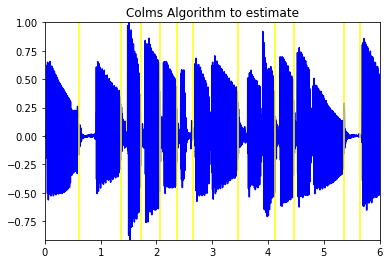

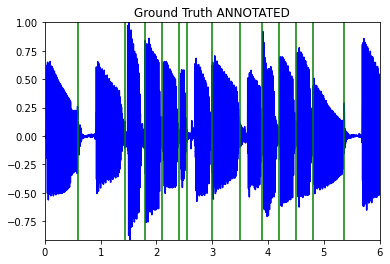

[0.6037188 1.3699774 1.7182766 2.066576  2.3684354 2.647075  3.4597733
 4.133152  4.4582314 5.3638096 5.642449 ]
[ 0.6     1.4341  1.8     2.1     2.3995  2.5552  3.      3.5066  3.9
  4.2     4.5     4.8     5.3545  6.237   6.6     6.9     7.2     7.3944
  7.8     8.4     8.7     9.      9.3     9.6    10.2356 11.033  11.4
 11.7    12.     12.1    12.6    13.2    13.5    13.8    14.1    14.4
 15.     15.84   16.2    16.5    16.8    16.9271 17.4    18.     18.3
 18.6    18.9    19.2   ]


In [ ]:
#rms, b=calculate_abOffset(g1,0.02,frameSize,hopSize,50) # Long inter note gap
rms, b=calculate_abOffset(g2,0.1,frameSize,hopSize,90) # short inter note gap

# Decide on a criteria to decide when onset and offset align
plt.plot(np.arange(g2.size)/float(fs), g2,'b')
plt.axis([0,g2.size/float(fs),min(g2),max(g2)])
for i in b:
    plt.axvline(x=i, color='yellow')
plt.title("Colms Algorithm to estimate")
plt.show()

go2 = array(golden_offsets2)



plt.plot(np.arange(g2.size)/float(fs), g2,'b')
plt.axis([0,g2.size/float(fs),min(g2),max(g2)])
for i in go2:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth ANNOTATED")
plt.show()
print(b)
print(go2)

# Decide on a criteria to decide when onset and offset align
plt.plot(np.arange(g2.size)/float(fs), g2,'b')
plt.axis([0,g2.size/float(fs),min(g2),max(g2)])
for i in b:
    plt.axvline(x=i, color='yellow')
plt.title("Onsets")
plt.show()





[  7.  19.  50.  66.  97. 109. 144. 187. 224.]
258


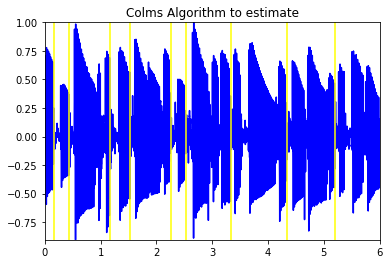

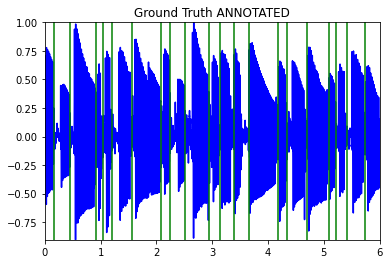

In [ ]:
rms, b=calculate_abOffset(g4,0.1,frameSize,hopSize,90) # short inter note gap

# Decide on a criteria to decide when onset and offset align
plt.plot(np.arange(g4.size)/float(fs), g4,'b')
plt.axis([0,g4.size/float(fs),min(g4),max(g4)])
for i in b:
    plt.axvline(x=i, color='yellow')
plt.title("Colms Algorithm to estimate")
plt.show()

go4 = array(golden_offsets4)

plt.plot(np.arange(g4.size)/float(fs), g4,'b')
plt.axis([0,g4.size/float(fs),min(g4),max(g4)])
for i in go4:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth ANNOTATED")
plt.show()

[ 23.  56.  90. 133. 161. 198. 231.]
258


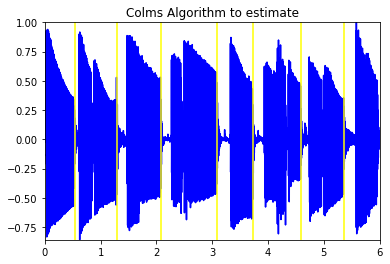

In [ ]:
#rms, b=calculate_abOffset(g10,0.02,frameSize,hopSize,50) # Long inter note gap
rms, b=calculate_abOffset(g10,0.1,frameSize,hopSize,90) # short inter note gap

# Decide on a criteria to decide when onset and offset align
plt.plot(np.arange(g10.size)/float(fs), g10,'b')
plt.axis([0,g10.size/float(fs),min(g10),max(g10)])
for i in b:
    plt.axvline(x=i, color='yellow')
plt.title("Colms Algorithm to estimate")
plt.show()

go10 = array(golden_offsets10)

plt.plot(np.arange(g10.size)/float(fs), g10,'b')
plt.axis([0,g10.size/float(fs),min(g10),max(g10)])
for i in g10:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth ANNOTATED")
plt.show()

In [ ]:
#rms, b=calculate_abOffset(g12,0.02,frameSize,hopSize,50) # Long inter note gap
rms, b=calculate_abOffset(g12,0.1,frameSize,hopSize,90) # short inter note gap

# Decide on a criteria to decide when onset and offset align
plt.plot(np.arange(g12.size)/float(fs), g12,'b')
plt.axis([0,g12.size/float(fs),min(g12),max(g12)])
for i in b:
    plt.axvline(x=i, color='yellow')
plt.title("Colms Algorithm to estimate")
plt.show()

go12= array(golden_offsets12)

plt.plot(np.arange(g12.size)/float(fs), g12,'b')
plt.axis([0,g12.size/float(fs),min(g12),max(g12)])
for i in g12:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth ANNOTATED")
plt.show()